In [25]:
import pandas as pd
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold, RepeatedKFold, ParameterGrid, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from xgboost import XGBClassifier
import joblib
import lightgbm as lgb
import os

In [26]:
def split_features_and_labels(dataframe: pd.DataFrame) -> pd.DataFrame:
    features = dataframe.iloc[:, :-11]  # All columns except the last eleven
    labels = dataframe.iloc[:, -11:]    # The last eleven columns
    return features, labels

In [27]:

# Load embeddings data
embeddings_file = "image_embeddings.pt"

embeddings_dict = torch.load(embeddings_file)

products = pd.read_csv('data/product_with_attributes.csv')
embeddings = [embeddings_dict[filename] for filename in products['des_filename']]

# embeddings = [embedding.numpy() for embedding in embeddings]

features, labels = split_features_and_labels(products)

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Add each dimension as a separate feature
for i in range(512):
    features[f'embedding_dim_{i}'] = embeddings_array[:, i]

label_encoder_dict = {}
encoded_labels = pd.DataFrame()
for label in labels.columns:
    label_encoder = LabelEncoder()
    encoded_labels[label] = label_encoder.fit_transform(labels[label])
    label_encoder_dict[label] = label_encoder
    

/tmp/ipykernel_9007/1941854610.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_dict = torch.load(embeddings_file)
/tmp/ipykernel_9007/1941854610.py:18: Settin

In [28]:
features = features.drop('cod_modelo_color', axis=1)
features = features.drop('des_filename', axis=1)
features.head(1)

,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_color,embedding_dim_0,...,embedding_dim_502,embedding_dim_503,embedding_dim_504,embedding_dim_505,embedding_dim_506,embedding_dim_507,embedding_dim_508,embedding_dim_509,embedding_dim_510,embedding_dim_511
0,Female,Kids,KIDS,TRICOT,Tops,Sweaters and Cardigans,Sweater,Sweater,ROSA LIGHT,0.088515,...,0.252419,-0.853426,-0.126018,-0.65395,0.638628,0.435513,0.365749,0.165159,0.394995,0.221404


In [29]:
features_arr = np.array(features)
 
features_arr.shape


(61484, 521)

In [30]:
invalid_types = torch.load('invalid_types.pth')
X_train_dict = dict()
y_train_dict = dict()
X_test_dict = dict()
y_test_dict = dict()

feature_encoder_dict = dict()
for feature_idx in range(0, 9):
    le = LabelEncoder()
    features_arr[:, feature_idx] = le.fit_transform(features_arr[:, feature_idx])

    feature_encoder_dict[feature_idx] = le

/tmp/ipykernel_9007/1548377039.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  invalid_types = torch.load('invalid_types.pth')


In [31]:
for label in labels.columns:
    # print(features_arr[:, 7])
    transformed_features = feature_encoder_dict[7].inverse_transform(features_arr[:, 7].astype(int))

    mask = np.isin(transformed_features, invalid_types[label])

    # filtered_features = features_arr[~mask]
    # filtered_encoded_labels = encoded_labels[label][~mask]
    
    filtered_features = features_arr
    filtered_encoded_labels = encoded_labels[label]

    print(filtered_features.shape)
    
    # X_train_dict[label], X_test_dict[label], y_train_dict[label], y_test_dict[label] = train_test_split(filtered_features, filtered_encoded_labels, test_size=0.1, random_state=42)
    X_train_dict[label] = filtered_features
    y_train_dict[label] = filtered_encoded_labels

(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)
(61484, 521)


In [19]:
X_train_dict['toecap_type'].shape

(55335, 521)

In [33]:

for label in labels:

    # clf = XGBClassifier(
    #     use_label_encoder=False,
    #     eval_metric='mlogloss',
    #     n_jobs=-1,
    #     max_depth=5,                # Reduced depth
    #     learning_rate=0.01,         # Lower learning rate
    #     n_estimators=1000,          # Increased number of trees
    #     subsample=0.8,              # Use 80% of the data for each tree
    #     colsample_bytree=0.8,       # Use 80% of the features for each tree
    #     gamma=0.3,                  # Increased gamma for regularization
    #     min_child_weight=10,        # Increased to make the model more conservative
    #     reg_alpha=0.5,              # L1 regularization
    #     reg_lambda=1,               # L2 regularization
    #     random_state=42             # For reproducibility
    # )
    
    clf = XGBClassifier( # MID
        # use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1,
        max_depth=8,
        learning_rate=0.1,
        n_estimators=400,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        min_child_weight=5
    )

    print("Shape:", X_train_dict[label].shape)
    
    clf.fit(X_train_dict[label], y_train_dict[label])

    # Save the model
    model_filename = f"model_{label}_xgb_cat_6.joblib"
    joblib.dump(clf, model_filename)
    
    
    # Use XGBoost as an example
    # clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
    # clf = XGBClassifier( # MID
    #     use_label_encoder=False,
    #     eval_metric='mlogloss',
    #     n_jobs=-1,
    #     max_depth=8,
    #     learning_rate=0.1,
    #     n_estimators=200,
    #     # subsample=0.8,
    #     # colsample_bytree=0.8,
    #     gamma=0.1,
    #     min_child_weight=5
    # )
    # clf = lgb.LGBMClassifier(
    #     n_estimators=200,
    #     learning_rate=0.1,
    #     max_depth=8,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     min_child_weight=5,
    #     n_jobs=-1,
    #     verbose=-1
    # )
    # clf.fit(X_train, y_train[label])

Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)
Shape: (61484, 521)


In [32]:
model_lo_p = "model_neck_lapel_type_ada_1.joblib"  # Replace with your actual file name
model_lo = joblib.load(model_lo_p)

In [10]:
y_pred = model_lo.predict(X_test)
yo = labels['neck_lapel_type']

In [16]:
y_test['neck_lapel_type'].shape

(12297,)

In [18]:
accuracy = accuracy_score(y_test['neck_lapel_type'], y_pred)
accuracy

0.6856956981377572

### GridSearch

In [30]:
def print_model_accuracy(model):
    y_pred_test = model.predict(X_test_dict[label])
    accuracy_test = accuracy_score(y_test_dict[label], y_pred_test)
    y_pred_train = model.predict(X_train_dict[label])
    accuracy_train = accuracy_score(y_train_dict[label], y_pred_train)
    print(f"{label:^20}{accuracy_train:^20.4f}{accuracy_test:^20.4f}")

In [32]:
label = labels.columns[-4]

param_dist = {
    'max_depth': [3, 5],
    'learning_rate': 0.1,
    'n_estimators': [100, 500, 1000],
    'subsample': 0.8,
    'colsample_bytree': [0.8, 1.0],
    'gamma': 0,
    'min_child_weight': 1,
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}


model = XGBClassifier(
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

random_search = GridSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_dict[label], y_train_dict[label])

best_model = random_search.best_estimator_

/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:50:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:51:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:51:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/guimcc/anaconda3/envs/datascie

TypeError: print_model_accuracy() takes 1 positional argument but 2 were given

In [33]:
print_model_accuracy(best_model)

model_filename = f"model_{label}_separate_11.joblib"
joblib.dump(clf, model_filename)

  cane_height_type         1.0000              0.9969       


['model_cane_height_type_separate_11.joblib']

In [34]:
best_model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'mlogloss',
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0.1,
 'reg_lambda': 1.5,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

### Test

In [24]:
models = {}

for label in labels:
    model_filename = f"model_{label}_xgb_cat_4.joblib"
    
    models[label] = joblib.load(model_filename)

In [ ]:
for label in labels:
    model = models[label]
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test[label], y_pred)
    print(f"Accuracy for {label}: {accuracy}")

In [34]:
PATH = "/media/guimcc/Elements/datathon"
IMAGES_PATH = f"{PATH}/archive/images/images/"
CSV_PATH = f"{PATH}/archive/"
HEIGHT = 224
WIDTH = 160

In [43]:
embeddings_file_test = "image_embeddings_test.pt"
embeddings_dict_test = torch.load(embeddings_file_test)
df_test = pd.read_csv(f"{CSV_PATH}/test_data.csv")

# def update_image_path(path):
#     # print(path)
#     # print(path[:-4])

    
#     if path[:-4].endswith('_'):
        
#         new_path = path.replace('_.jpg', '_B.jpg')
#         # print(f'{IMAGES_PATH}{new_path}')
#         if os.path.exists(f'{IMAGES_PATH}{new_path}'):
#             print("AAAAAAAAA", f'{IMAGES_PATH}{new_path}')
#             return new_path
#     return path

# df_test['des_filename'] = df_test['des_filename'].apply(update_image_path)

/tmp/ipykernel_362339/2449148042.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_dict_test = torch.load(embeddings_file_test)


In [40]:
df_test['des_filename']

0         88_49711373_67080432-99_.jpg
1         88_49718802_67030656-99_.jpg
2        88_49709572_67030418-01_B.jpg
3         88_49722701_67066002-02_.jpg
4        88_49724926_67056330-02_B.jpg
                     ...              
71814     88_49727540_67069223-56_.jpg
71815     88_49733648_67017145-56_.jpg
71816     88_49735572_67076755-81_.jpg
71817     88_49713624_67092528-70_.jpg
71818     88_49726160_67076040-99_.jpg
Name: des_filename, Length: 71819, dtype: object

In [122]:
embeddings_test = [embeddings_dict_test[filename] for filename in df_test['des_filename']]

embeddings_test = np.array(embeddings_test)

In [123]:
predictions = pd.DataFrame()
predictions['des_filename'] = df_test['des_filename']
predictions['test_id'] = df_test['test_id']
for label in labels:
    model = models[label]
    prediction = model.predict(embeddings_test)
    predictions[label] = prediction


In [25]:
feature_encoder_dict[0].classes_

array([0, 1, 2], dtype=object)

In [35]:
test = pd.read_csv(f'{CSV_PATH}test_data.csv')
embeddings_test = torch.load('image_embeddings_test.pt')


models = {label: joblib.load(f"model_{label}_xgb_cat_6.joblib") for label in labels.columns} # SOC SUBNORMAL
# models['silhouette_type'] = joblib.load(f"./models/model_silhouette_type_xgb_cat_6.joblib")

/tmp/ipykernel_9007/2771983030.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_test = torch.load('image_embeddings_test.pt')


In [36]:
count = 0


col_names = ['des_sex', 'des_age',	'des_line',	'des_fabric', 'des_product_category', 'des_product_aggregated_family', 'des_product_family', 'des_product_type', 'des_color']
predictions = pd.DataFrame()
predictions['test_id'] = test['test_id']

for index, row in tqdm(test.iterrows()):
    splitted = row['test_id'].split('_')
    product_id = '_'.join(splitted[:2])
    attribute = '_'.join(splitted[2:])

    if test.loc[index]['des_product_type'] in invalid_types[attribute]:
        predictions.loc[index, 'des_value'] = 'INVALID'
        count += 1
        continue
    
    encoded_features = np.zeros((1, 9))
    for feature_idx in range(0, 9):
        le = feature_encoder_dict[feature_idx]
        # print(col_names[feature_idx])
        try:
            encoded_features[0][feature_idx] = le.transform([test.loc[index, col_names[feature_idx]]])[0]
        except ValueError:
            # print(f"Value not found: {test.loc[index, col_names[feature_idx]]}")
            encoded_features[0][feature_idx] = np.nan
        
    
    # Make a prediction for each attribute
    key = test.loc[index]['des_filename']
    model = models[attribute]
    embedding = embeddings_test[key].numpy()
    embedding = embedding.reshape(1, -1)
    
    # print(encoded_features.shape, embedding.shape)
    
    input_features = np.concatenate((encoded_features, embedding), axis=1)
    # print(input_features.shape)
    
    prediction = model.predict(input_features)
    predictions.loc[index, 'des_value'] = label_encoder_dict[attribute].inverse_transform(prediction) #unique_values[attribute][prediction[0]]

print(count)

71819it [01:50, 649.45it/s] 

33535


In [37]:
predictions.to_csv('data/submission_final.csv', index=False)

# Plots

In [28]:
models = {label: joblib.load(f"model_{label}_xgb_cat_1.joblib") for label in labels.columns}

In [29]:
print(f"{'Label':^20}{'Train Accuracy':^20}{'Test Accuracy':^20}")
print('-' * 65)
for label in labels:
    model = models[label]
    y_pred_test = model.predict(X_test_dict[label])
    accuracy_test = accuracy_score(y_test_dict[label], y_pred_test)
    y_pred_train = model.predict(X_train_dict[label])
    accuracy_train = accuracy_score(y_train_dict[label], y_pred_train)
    print(f"{label:^20}{accuracy_train:^20.4f}{accuracy_test:^20.4f}")

       Label           Train Accuracy      Test Accuracy    
-----------------------------------------------------------------
  silhouette_type          0.9576              0.6438       
  neck_lapel_type          0.9735              0.7587       
  woven_structure          0.9739              0.7933       
   knit_structure          0.9943              0.9501       
  heel_shape_type          0.9990              0.9909       
    length_type            0.9700              0.7546       
 sleeve_length_type        0.9886              0.9060       
    toecap_type            0.9991              0.9925       
     waist_type            0.9895              0.9114       
 closure_placement         0.9840              0.8535       
  cane_height_type         0.9996              0.9967       


57923

Accuracy for silhouette_type: 0.9218617820209588


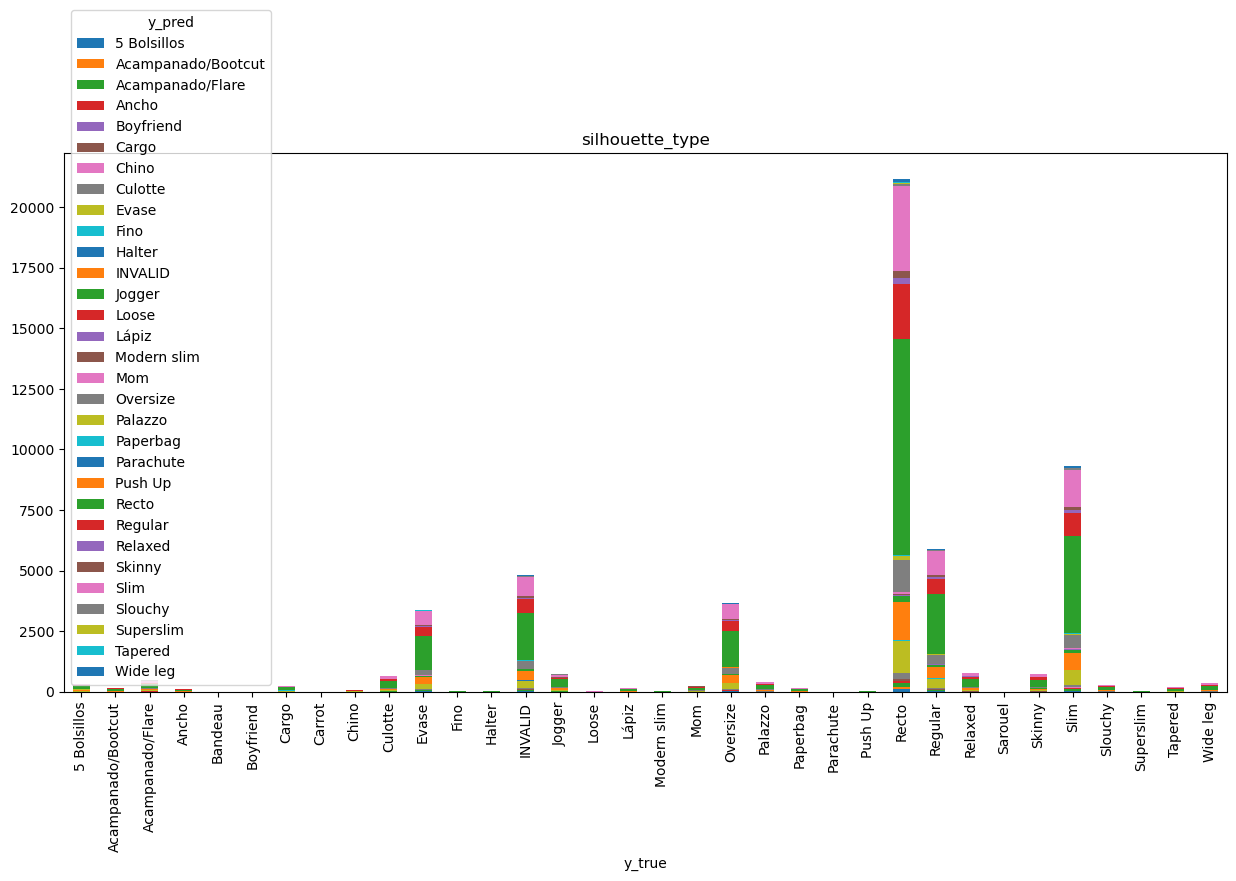

43788

Accuracy for neck_lapel_type: 0.9326756188910204


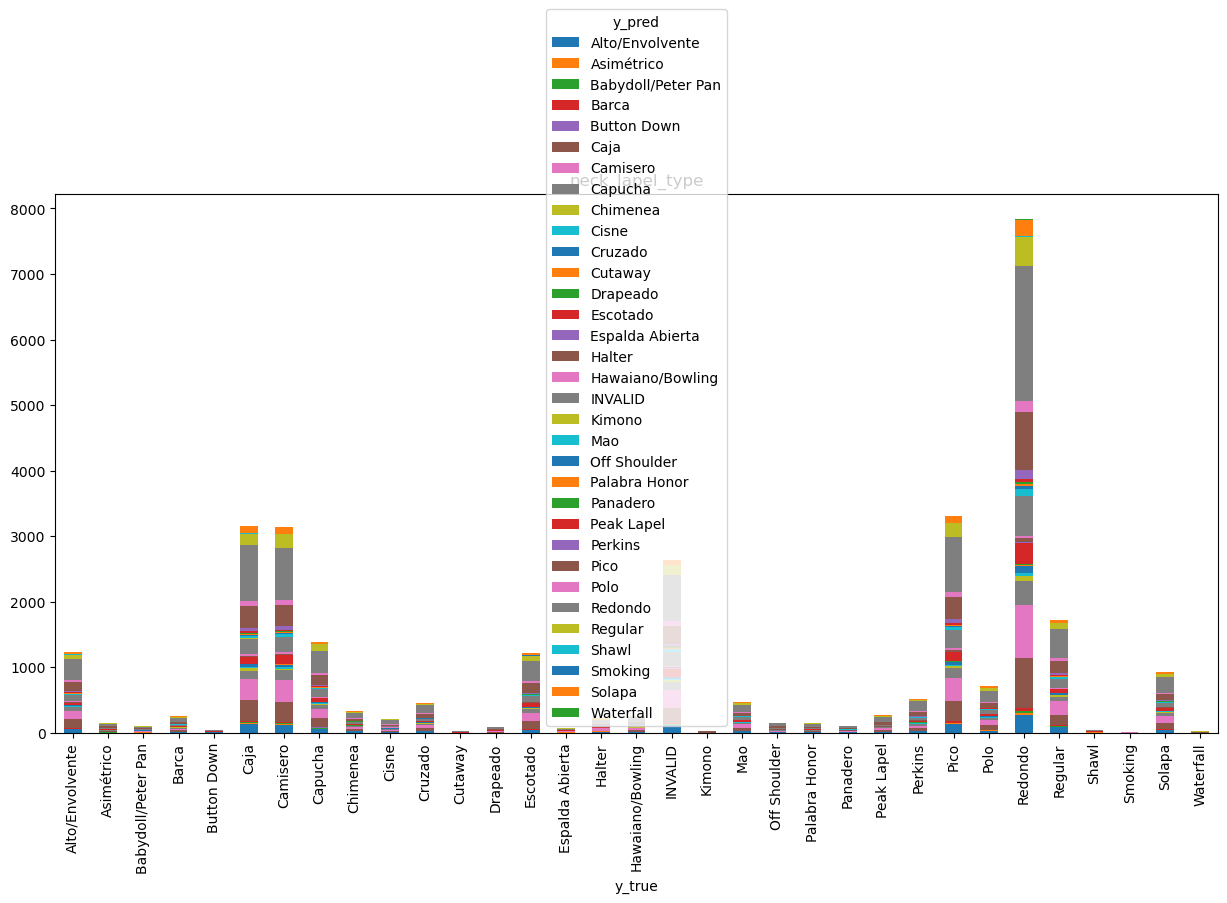

58894

Accuracy for woven_structure: 0.9539002275274221


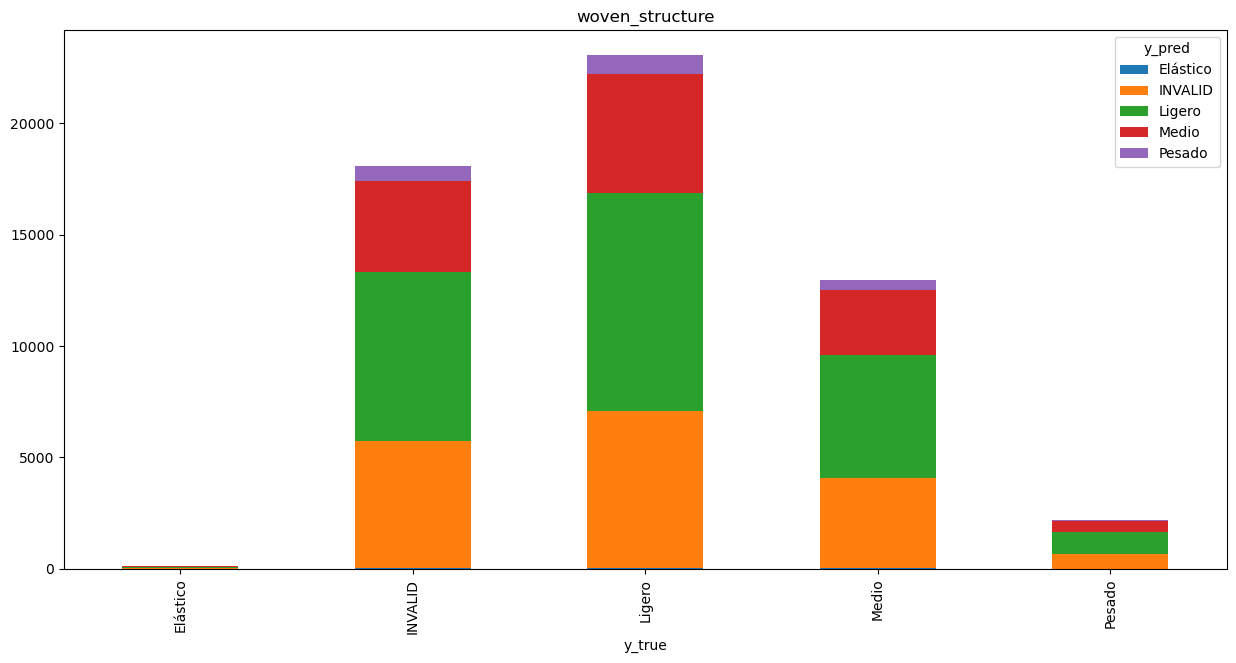

47896

Accuracy for knit_structure: 0.9869717721730416


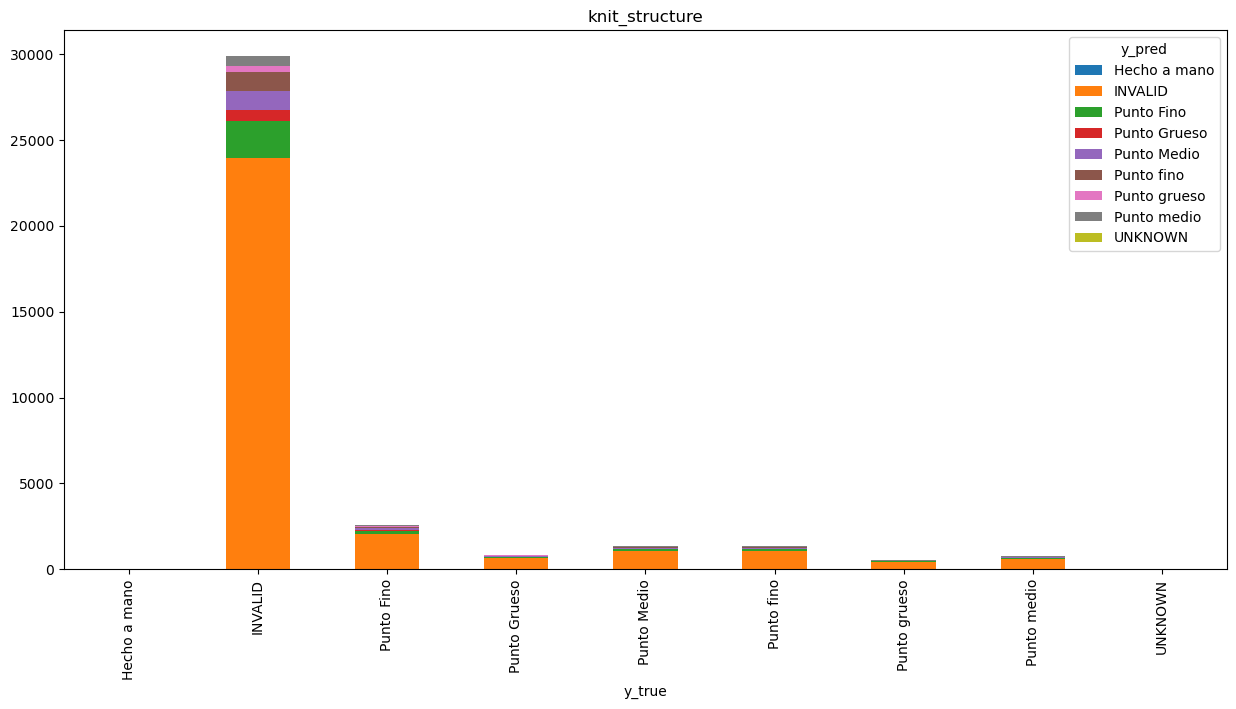

2399

Accuracy for heel_shape_type: 0.9541475614839516


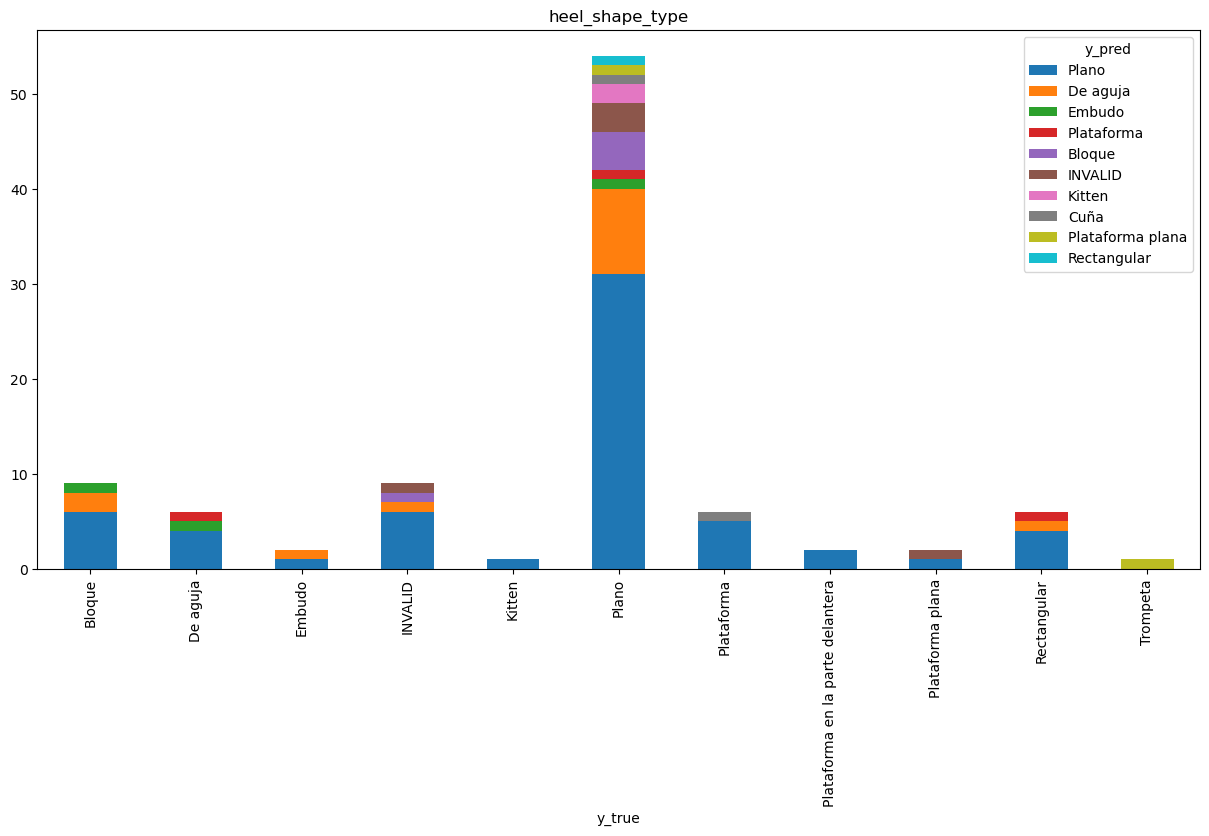

57769

Accuracy for length_type: 0.9453166923436445


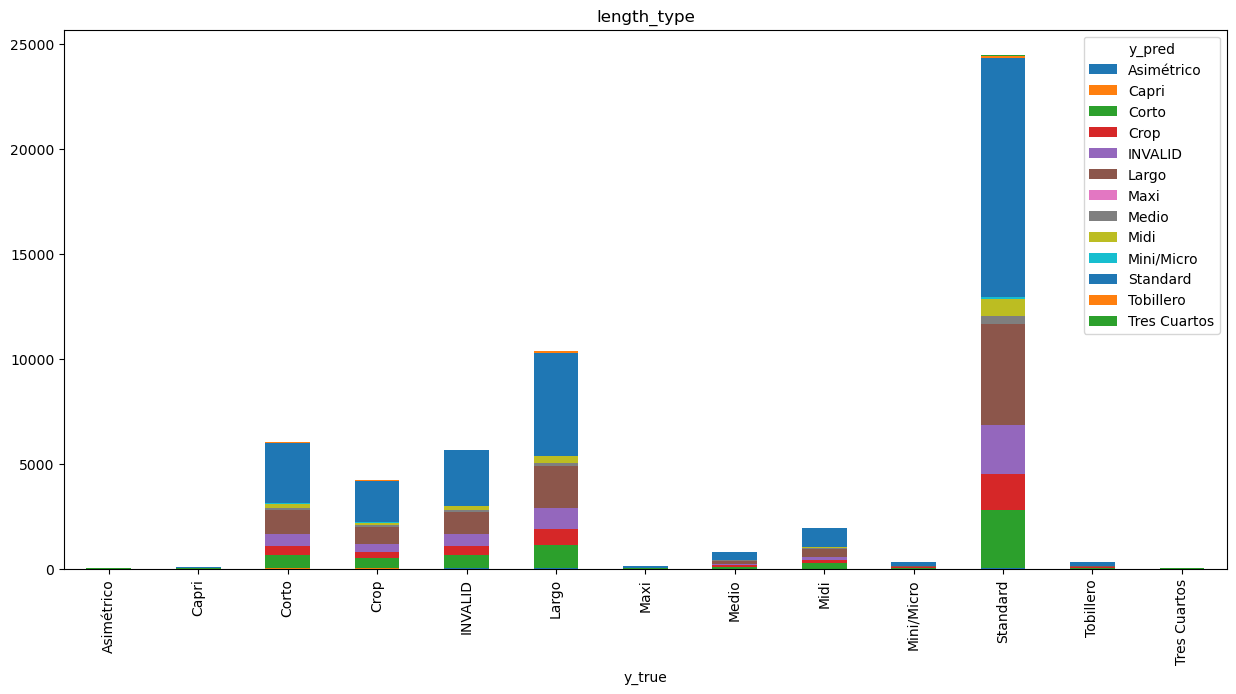

42353

Accuracy for sleeve_length_type: 0.9717139281750997


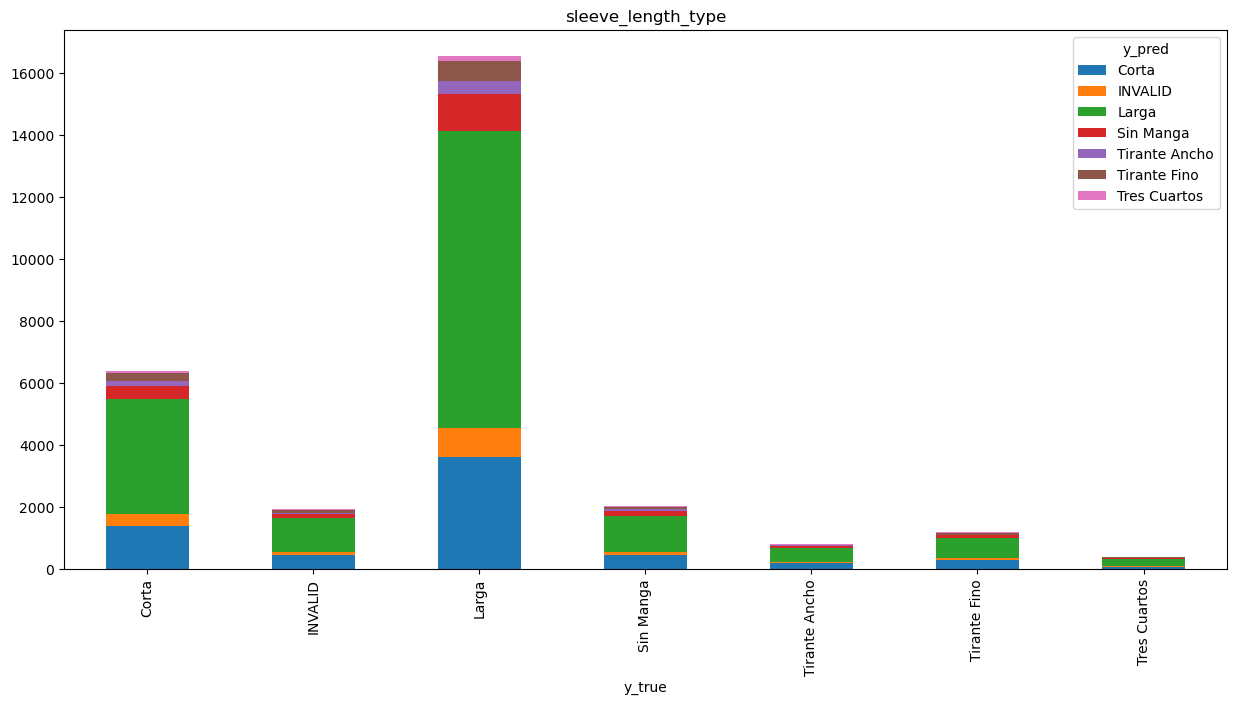

2399

Accuracy for toecap_type: 0.96040016673614


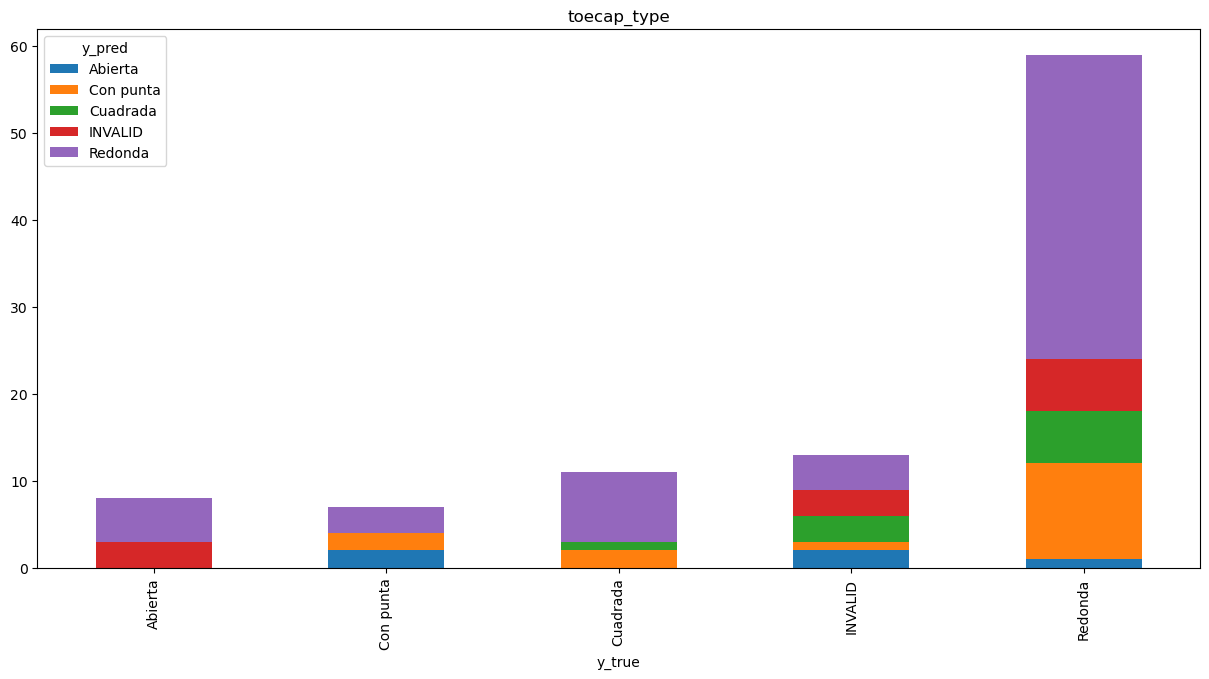

14678

Accuracy for waist_type: 0.9234228096470909


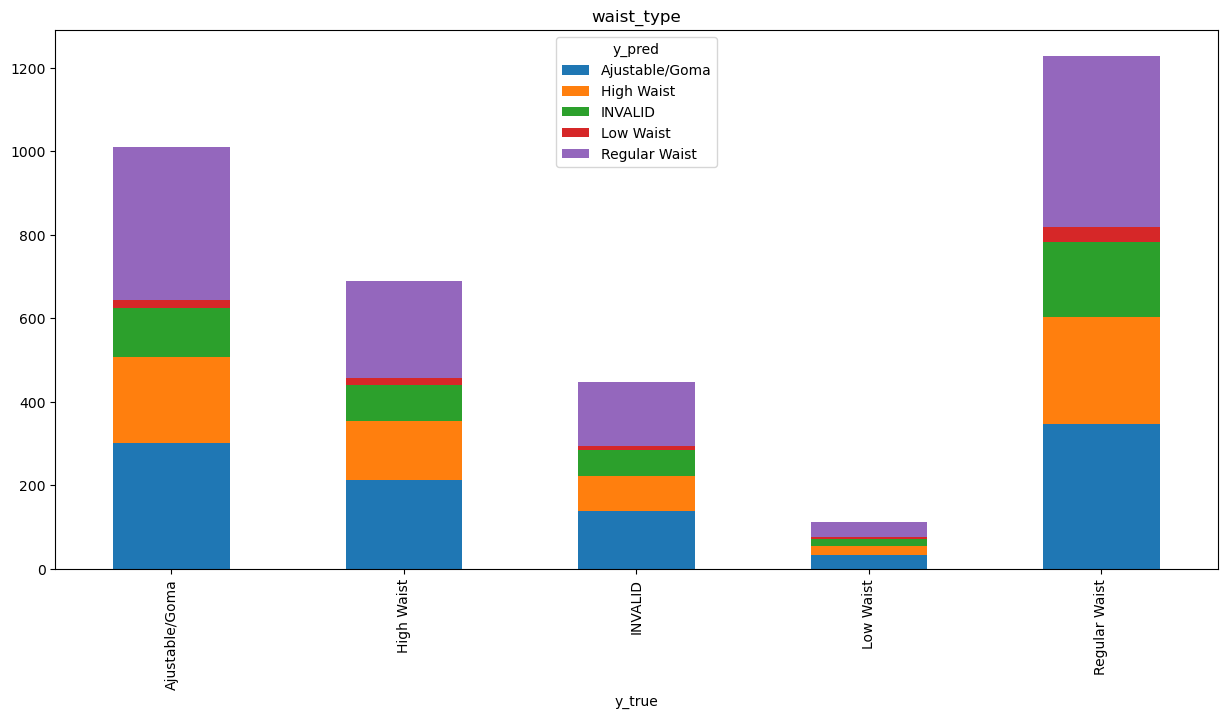

34461

Accuracy for closure_placement: 0.9486085720089377


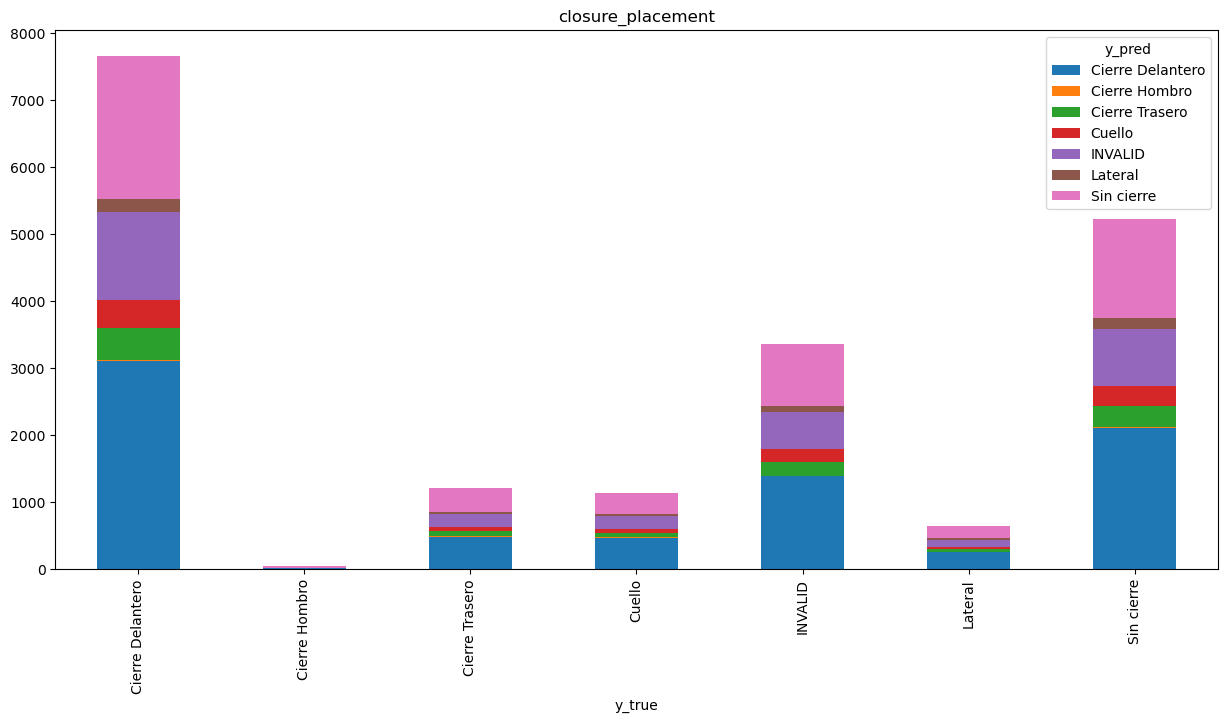

635

Accuracy for cane_height_type: 0.9338582677165355


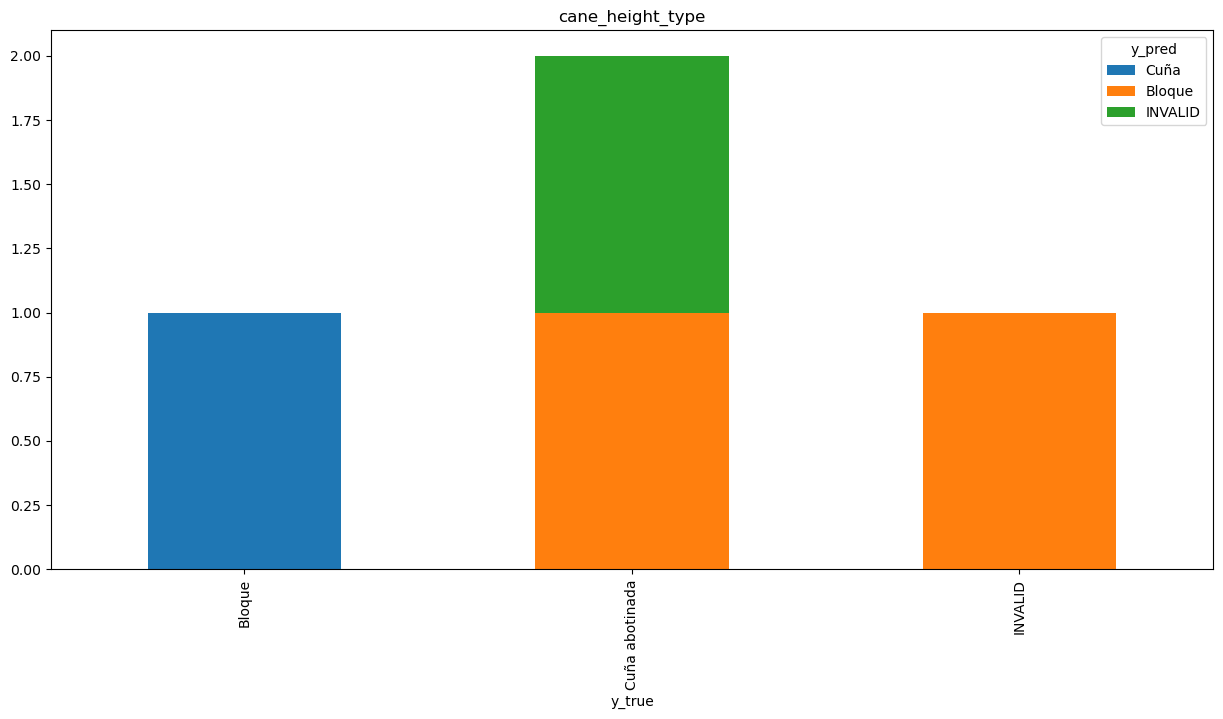

In [105]:
import matplotlib.pyplot as plt

for label in labels:
    model = models[label]
    y_pred = model.predict(X_train_dict[label])
    print(len(y_pred))
    accuracy = accuracy_score(y_train_dict[label], y_pred)
    print(f"\nAccuracy for {label}: {accuracy}")
    
    y_train_dict[label]
    y_test_data = y_train_dict[label].apply(lambda x: label_encoder_dict[label].inverse_transform([x])[0])
    y_pred_data = pd.Series(y_pred).apply(lambda x: label_encoder_dict[label].inverse_transform([x])[0])
    data = {'y_true': y_test_data, 'y_pred': y_pred_data}
    data = pd.DataFrame(data)
    data.groupby('y_true')['y_pred'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15, 7))
    plt.title(f'{label}')
    plt.show()


In [69]:
def split_features_and_labels(dataframe: pd.DataFrame) -> pd.DataFrame:
    features = dataframe.iloc[:, :-11]  # All columns except the last eleven
    labels = dataframe.iloc[:, -11:]    # The last eleven columns
    return features, labels

# Load embeddings data
embeddings_file = "image_embeddings.pt"

embeddings_dict = torch.load(embeddings_file)

products = pd.read_csv('data/product_with_attributes.csv')
embeddings = [embeddings_dict[filename] for filename in products['des_filename']]

features, labels = split_features_and_labels(products)

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Add each dimension as a separate feature
for i in range(512):
    features[f'embedding_dim_{i}'] = embeddings_array[:, i]

/tmp/ipykernel_9007/3287752943.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_dict = torch.load(embeddings_file)
/tmp/ipykernel_9007/3287752943.py:21: Settin

In [45]:
features.shape

(61484, 523)

In [70]:
# ENCODE THE VALUES
label_encoder_dict_inf = {}
encoded_labels_inf = pd.DataFrame()

for label in labels.columns:
    label_encoder_inf = LabelEncoder()
    encoded_labels_inf[label] = label_encoder_inf.fit_transform(labels[label])
    label_encoder_dict_inf[label] = label_encoder_inf

In [71]:
# FEATURE ENCODING
features = features.drop('cod_modelo_color', axis=1)
features = features.drop('des_filename', axis=1)
features_arr_inf = np.array(features)
invalid_types_inf = torch.load('invalid_types.pth')
X_train_dict_inf = dict()
y_train_dict_inf = dict()
X_test_dict_inf = dict()
y_test_dict_inf = dict()

/tmp/ipykernel_9007/4232816336.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  invalid_types_inf = torch.load('invalid_types.pth')


In [53]:
features_arr_inf

array([['Female', 'Kids', 'KIDS', ..., 0.16515854001045227,
        0.39499521255493164, 0.2214043140411377],
       ['Female', 'Kids', 'KIDS', ..., -0.468533992767334,
        0.5832499861717224, -0.24947479367256165],
       ['Female', 'Kids', 'KIDS', ..., 0.42598608136177063,
        0.4920598566532135, -0.25704225897789],
       ...,
       ['Female', 'Baby', 'KIDS', ..., 0.18469777703285217,
        -0.07330606132745743, 0.21562422811985016],
       ['Female', 'Adult', 'WOMAN', ..., 0.3402513861656189,
        0.1643792688846588, 0.1592748910188675],
       ['Female', 'Adult', 'WOMAN', ..., -0.07081132382154465,
        0.42564496397972107, 0.1500830054283142]], dtype=object)

In [72]:
feature_encoder_dict_inf = dict()
for feature_idx in range(0, 9):
    le = LabelEncoder()
    features_arr_inf[:, feature_idx] = le.fit_transform(features_arr_inf[:, feature_idx])
    feature_encoder_dict_inf[feature_idx] = le


In [61]:
feature_encoder_dict_inf[5].classes_

array(['Accessories', 'Coats and Parkas', 'Dresses and jumpsuits',
       'Jackets and Blazers', 'Jeans', 'Shirts', 'Skirts and shorts',
       'Sweaters and Cardigans', 'T-shirts', 'Tops',
       'Trousers & leggings'], dtype=object)

In [74]:
input_embedding = embeddings_array[0]

categorical_values = ['Male', 'Adult', 'MAN', 'CIRCULAR', 'Tops', 'T-shirts', 'T-shirt', 'T-Shirt', 'CELESTE']

# Encode the features
encoded_features = np.zeros((1, 9))
for feature_idx in range(0, 9):
    le = feature_encoder_dict_inf[feature_idx]
    encoded_features[0][feature_idx] = le.transform([categorical_values[feature_idx]])[0]

models = {label: joblib.load(f"model_{label}_xgb_cat_2.joblib") for label in labels.columns}

predictions = []
for label in labels:
    print(encoded_features.shape, input_embedding.shape)
    
    input_features = np.concatenate((encoded_features, input_embedding), axis=1)
    
    prediction = model.predict(input_features)
    predictions.append(label_encoder_dict_inf[label].inverse_transform(prediction)[0])


(1, 9) (512,)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [85]:
def inference_on_embedding(input_embedding):
    def split_features_and_labels(dataframe: pd.DataFrame) -> pd.DataFrame:
        features = dataframe.iloc[:, :-11]  # All columns except the last eleven
        labels = dataframe.iloc[:, -11:]    # The last eleven columns
        return features, labels

    # Load embeddings data
    embeddings_file = "image_embeddings.pt"

    embeddings_dict = torch.load(embeddings_file)

    products = pd.read_csv('data/product_with_attributes.csv')
    embeddings = [embeddings_dict[filename] for filename in products['des_filename']]

    features, labels = split_features_and_labels(products)

    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)

    # Add each dimension as a separate feature
    for i in range(512):
        features[f'embedding_dim_{i}'] = embeddings_array[:, i]
        
    # ENCODE THE VALUES
    label_encoder_dict_inf = {}
    encoded_labels_inf = pd.DataFrame()

    for label in labels.columns:
        label_encoder_inf = LabelEncoder()
        encoded_labels_inf[label] = label_encoder_inf.fit_transform(labels[label])
        label_encoder_dict_inf[label] = label_encoder_inf
        
    # FEATURE ENCODING
    features = features.drop('cod_modelo_color', axis=1)
    features = features.drop('des_filename', axis=1)
    features_arr_inf = np.array(features)
    
    feature_encoder_dict_inf = dict()
    for feature_idx in range(0, 9):
        le = LabelEncoder()
        features_arr_inf[:, feature_idx] = le.fit_transform(features_arr_inf[:, feature_idx])
        feature_encoder_dict_inf[feature_idx] = le

    categorical_values = ['Male', 'Adult', 'MAN', 'CIRCULAR', 'Tops', 'T-shirts', 'T-shirt', 'T-Shirt', 'CELESTE']

    # Encode the features
    encoded_features = np.zeros((1, 9))
    for feature_idx in range(0, 9):
        le = feature_encoder_dict_inf[feature_idx]
        encoded_features[0][feature_idx] = le.transform([categorical_values[feature_idx]])[0]

    models = {label: joblib.load(f"model_{label}_xgb_cat_2.joblib") for label in labels.columns}
    
    embedding = input_embedding.reshape(1, -1)

    predictions = []
    for label in labels:
        
        input_features = np.concatenate((encoded_features, embedding), axis=1)
        model = models[label]
        
        prediction = model.predict(input_features)
        predictions.append(label_encoder_dict_inf[label].inverse_transform(prediction)[0])
                
    return predictions

In [86]:
a = inference_on_embedding(embeddings_array[0])

/tmp/ipykernel_9007/1535915386.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_dict = torch.load(embeddings_file)
/tmp/ipykernel_9007/1535915386.py:22: Setti

AAAAAAA ['Recto', 'Redondo', 'Ligero', 'INVALID', 'INVALID', 'Standard', 'Larga', 'INVALID', 'INVALID', 'INVALID', 'INVALID']


In [87]:
a

['Recto',
 'Redondo',
 'Ligero',
 'INVALID',
 'INVALID',
 'Standard',
 'Larga',
 'INVALID',
 'INVALID',
 'INVALID',
 'INVALID']

In [ ]:
input_embedding